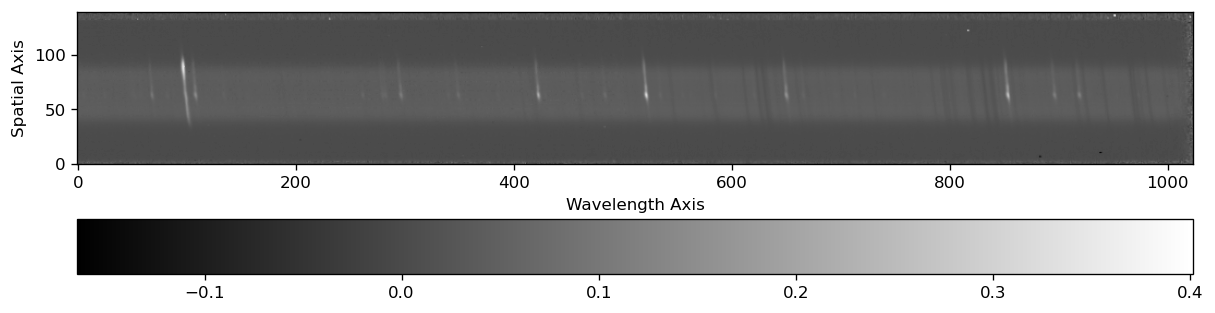

In [9]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p_map.ipynb.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 61 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec = nirspec7_data_array[fn_spec-start_nirspec7]
sky_subtracted = (target_spec - sky_total) / (average_flat_field - average_flat_lamp_off)
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,6))
plt.imshow(sky_subtracted, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.xlim(500,600)
#plt.ylim(100,1)
plt.colorbar(orientation='horizontal', pad=0.1)


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

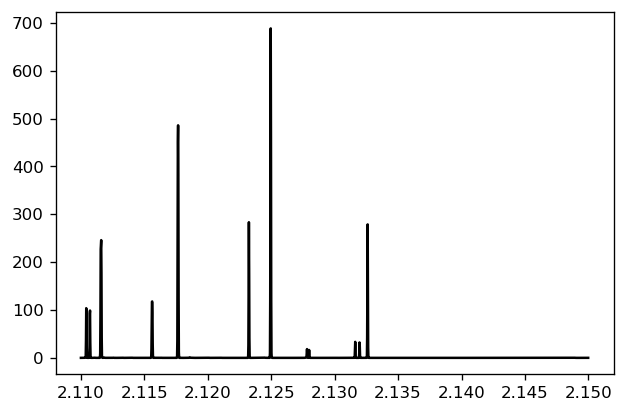

In [11]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[60500:62500,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[60500:62500,1]#[gemini_array[60500:62500,1]>0.5]

plt.plot(wavelength, count, 'k')
#plt.xlim(min(wavelength), max(wavelength))
#plt.xlim(2.11,2.15)
#plt.xlim(2.132,2.133)
#plt.ylim(min(count), 800)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 2000
    # variables        = 6
    chi-square         = 1191667.40
    reduced chi-square = 597.626579
    Akaike info crit   = 12791.9232
    Bayesian info crit = 12825.5286
[[Variables]]
    a0:  692.744456 +/- 21.6923162 (3.13%) (init = 692)
    a1:  2.12496000 +/- 7.7693e-07 (0.00%) (init = 2.125)
    a2:  9.7318e-04 +/- 2.3439e-05 (2.41%) (init = 0.004)
    a3:  36579.6693 +/- 20819.4136 (56.92%) (init = 0)
    a4: -34121.4975 +/- 19549.2942 (57.29%) (init = 0)
    a5:  7957.19951 +/- 4589.05680 (57.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.574


2.124959996615822

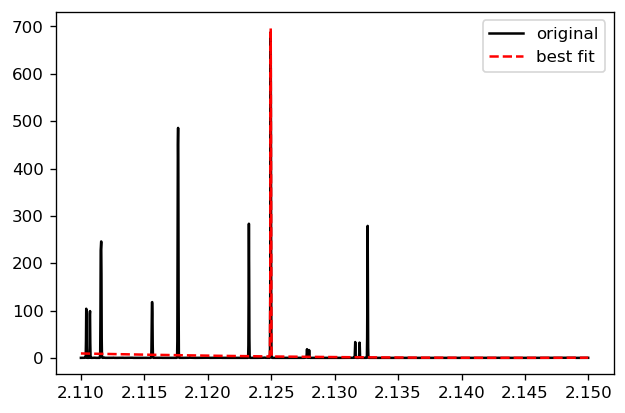

In [12]:
# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g1model.param_names))
#print('independent variables: {}'.format(g1model.independent_vars))


# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=692)
g1_params.add('a1', value=2.125)
g1_params.add('a2', value=0.004)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(count, g1_params, x=wavelength)
except:
    pass

print(g1_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g1_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.1246,2.1252)

g1_result.params['a1'].value

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 2000
    # variables        = 6
    chi-square         = 1968234.92
    reduced chi-square = 987.078697
    Akaike info crit   = 13795.4905
    Bayesian info crit = 13829.0959
[[Variables]]
    a0:  281.745623 +/- 29.5132383 (10.48%) (init = 290)
    a1:  2.12324201 +/- 2.3124e-06 (0.00%) (init = 2.12325)
    a2:  8.9566e-04 +/- 7.1761e-05 (8.01%) (init = 0.003)
    a3:  13890.0431 +/- 26743.6554 (192.54%) (init = 0)
    a4: -12797.1761 +/- 25112.1148 (196.23%) (init = 0)
    a5:  2947.18976 +/- 5894.88832 (200.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.569


2.1232420081711174

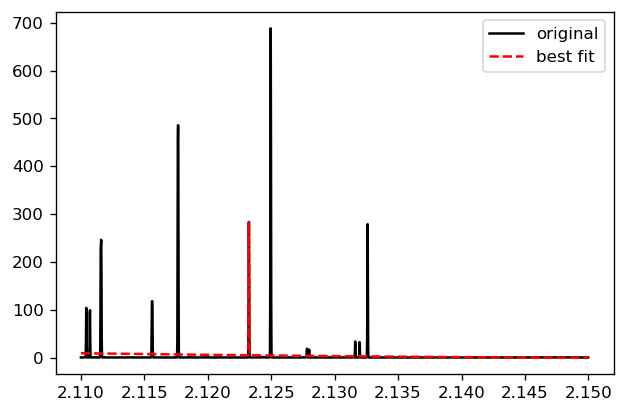

In [13]:
# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)

# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=290)
g2_params.add('a1', value=2.12325)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g2_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.123,2.1235)

g2_result.params['a1'].value

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 2000
    # variables        = 6
    chi-square         = 1970173.72
    reduced chi-square = 988.051013
    Akaike info crit   = 13797.4596
    Bayesian info crit = 13831.0651
[[Variables]]
    a0:  280.903097 +/- 29.6742776 (10.56%) (init = 290)
    a1:  2.13259700 +/- 2.3132e-06 (0.00%) (init = 2.1326)
    a2:  8.9078e-04 +/- 7.2196e-05 (8.10%) (init = 0.003)
    a3:  17929.9224 +/- 26776.3484 (149.34%) (init = 0)
    a4: -16567.2074 +/- 25142.7126 (151.76%) (init = 0)
    a5:  3826.68314 +/- 5902.04709 (154.23%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.570


2.1325969957673254

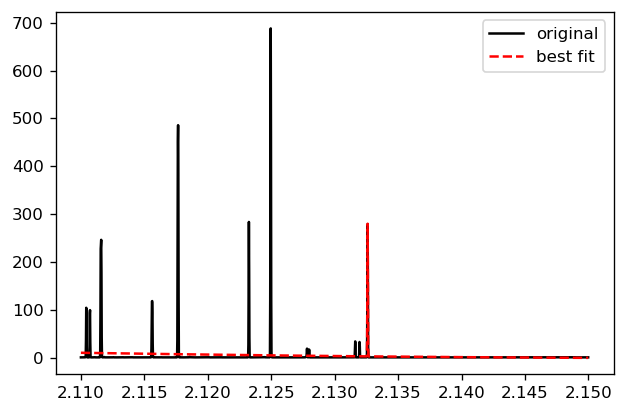

In [14]:
# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=290)
g3_params.add('a1', value=2.1326)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

print(g3_result.fit_report())

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
plt.plot(wavelength, g3_result.best_fit, 'r--', label='best fit')
plt.legend()
#plt.xlim(2.132,2.133)

g3_result.params['a1'].value

In [40]:
# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))


# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.15)
h2_params.add('a1', value=100)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)

In [52]:
"""
loop over all frames containing observed 
h2 emission for a0 at wavelength axis 107 
and obtain fitting parameters of each frame
"""

# confirm start and end frame number
start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# define range on spatial axis to fit
lower_h2 = 10
upper_h2 = 130

# create empty list to collect result
h2_a0_map = []

# scan selected range of frames
for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    # create zeros to replace by fitting params
    h2_a0 = np.zeros(upper_h2-lower_h2)
    #h2_a0_error = np.zeros(upper_h2-lower_h2)
    #h2_a1 = np.zeros(upper_h2-lower_h2)
    #h2_a1_error = np.zeros(upper_h2-lower_h2)
    #h2_a2 = np.zeros(upper_h2-lower_h2)
    #h2_a2_error = np.zeros(upper_h2-lower_h2)
    
    # fit gaussian to selected range of spatial axis of a frame
    for j in range(lower_h2, upper_h2):
        try:
            h2_fit_result = h2_model.fit(sky_subtract[j], h2_params, x=pixel)
            h2_a0[j] = h2_fit_result.params['a0'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.plot(h2_a0)
    
    h2_a0_map.append(h2_a0)
    
print('Done')

Done


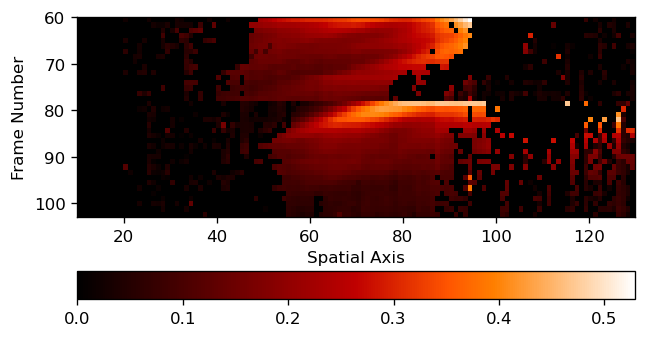

In [53]:
h2a0 = np.vstack((h2_a0_map))
h2a0[h2a0>0.5] = 0
h2a0[h2a0<0] = 0

plt.imshow(np.sqrt(h2a0), extent=[lower_h2, upper_h2, end_kband_north, start_kband_north], cmap='gist_heat')
#plt.title('H2 a0')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
#plt.xlim(20,140)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h2_a0_map_107', bbox_inches='tight')

In [54]:
"""
repeat same step for h2 a1 at wavelength axis 107
"""

lower_h2 = 10
upper_h2 = 130

start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h2_a1_map = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    h2_a1 = np.zeros(upper_h2-lower_h2)
    #h2_a1_error = np.zeros(upper_h2-lower_h2)
    
    for j in range(lower_h2, upper_h2):
        try:
            h2_fit_result = h2_model.fit(sky_subtract[j], h2_params, x=pixel)
            h2_a1[j] = h2_fit_result.params['a1'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a1', fontsize=12)
    #plt.plot(h2_a1)
    
    h2_a1_map.append(h2_a1)
    
print('Done')

Done


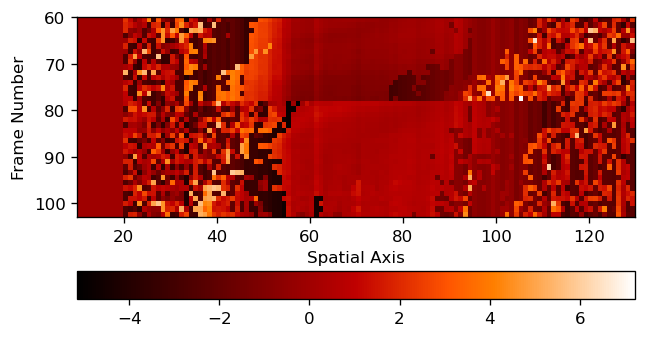

In [55]:
h2a1 = np.vstack((h2_a1_map))
h2a1[h2a1<96] = 96
h2a1[h2a1>104] = 104

plt.imshow(h2a1-(np.sum(h2a1, axis=0)/len(h2a1)), extent=[lower_h2, upper_h2, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
#plt.xlim(0,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h2_a1_map_107', bbox_inches='tight')

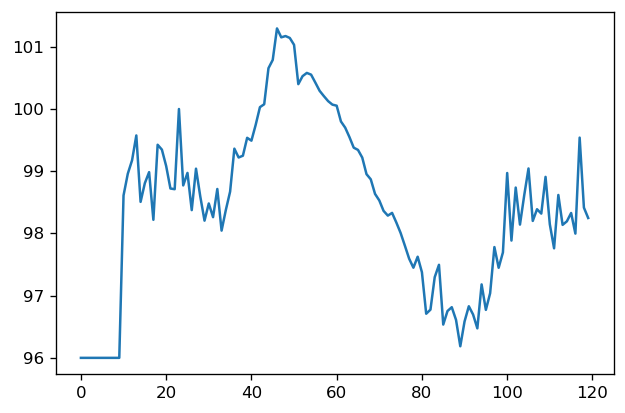

In [56]:
plt.plot(np.sum(h2a1, axis=0)/len(h2a1))

In [57]:
"""
repeat for h2 a2 at wavelength axis 107
"""
lower_h2 = 10
upper_h2 = 130

start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h2_a2_map = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    h2_a2 = np.zeros(upper_h2-lower_h2)
    #h2_a2_error = np.zeros(upper_h2-lower_h2)
    
    for j in range(lower_h2, upper_h2):
        try:
            h2_fit_result = h2_model.fit(sky_subtract[j], h2_params, x=pixel)
            h2_a2[j] = h2_fit_result.params['a2'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a2', fontsize=12)
    #plt.plot(h2_a2)
    
    h2_a2_map.append(h2_a2)
    
print('Done')

Done


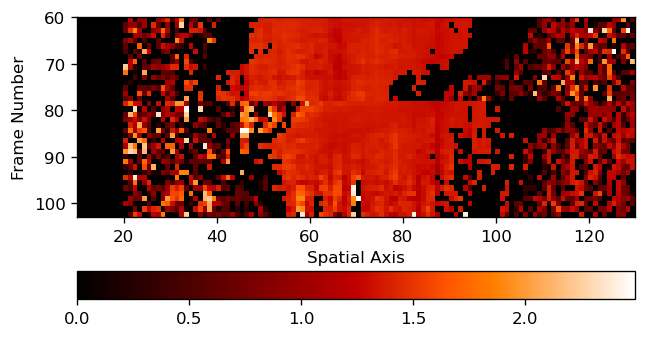

In [58]:
h2a2 = np.vstack((h2_a2_map))
h2a2[h2a2<0] = 0
h2a2[h2a2>2.5] = 0

plt.imshow(h2a2, extent=[lower_h2, upper_h2, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.xlim(20,140)
#plt.savefig('plots/h2_a2_map_107', bbox_inches='tight')

In [59]:
# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.1)
h3p_params.add('a1', value=522)
h3p_params.add('a2', value=1)
h3p_params.add('a3', value=0)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

In [60]:
"""
repeat for h3p a0 at wavelength axis 554
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a0_map = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.title('frame number ' + str(i))
    #plt.imshow(sky_subtract, cmap='gist_gray')
    
    h3p_a0 = np.zeros(upper_h3p-lower_h3p)
    #h3p_a0_error = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result = h3p_model.fit(sky_subtract[j], h3p_params, x=pixel)
            h3p_a0[j] = h3p_fit_result.params['a0'].value
        except:
            pass
    h3p_a0[h3p_a0<0] = 0
    h3p_a0[h3p_a0>0.25] = 0
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a0)), h3p_a0)
    
    h3p_a0_map.append(h3p_a0)
    
print('Done')

Done


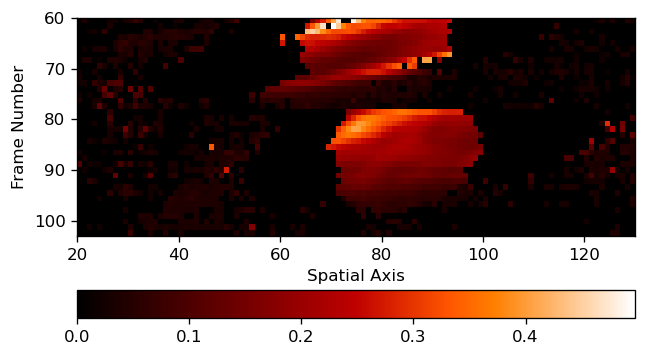

In [80]:
h3pa0 = np.vstack((h3p_a0_map))
#h3pa0[h3pa0>0.25] = 0

plt.imshow(np.sqrt(h3pa0), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a0_map_554', bbox_inches='tight')

In [62]:
"""
repeat for h3p a1 at wavelength axis 554
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a1_map = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    h3p_a1 = np.zeros(upper_h3p-lower_h3p)
    #h3p_a1_error = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result = h3p_model.fit(sky_subtract[j], h3p_params, x=pixel)
            h3p_a1[j] = h3p_fit_result.params['a1'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a1', fontsize=12)
    #plt.plot(h3p_a1)
    
    h3p_a1_map.append(h3p_a1)
    
print('Done')

Done


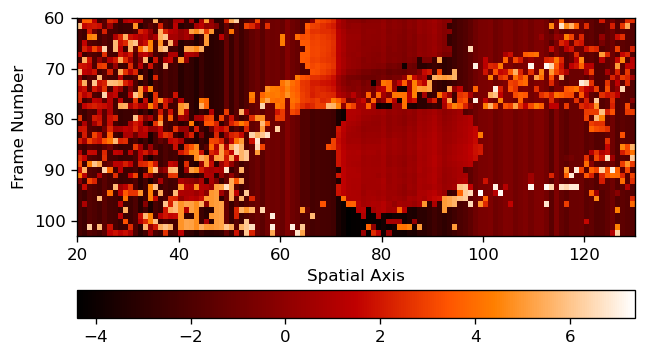

In [79]:
h3pa1 = np.vstack((h3p_a1_map))
h3pa1[h3pa1>526] = 526
h3pa1[h3pa1<518] = 518

plt.imshow(h3pa1-np.sum(h3pa1, axis=0)/len(h3pa1), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a1_map_554', bbox_inches='tight')

In [64]:
"""
repeat for h3p a2 at wavelength axis 554
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a2_map = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    h3p_a2 = np.zeros(upper_h3p-lower_h3p)
    #h3p_a2_error = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result = h3p_model.fit(sky_subtract[j], h3p_params, x=pixel)
            h3p_a2[j] = h3p_fit_result.params['a2'].value
        except:
            pass
    
    #h3p_a0[h3p_a0<0] = 0
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a2', fontsize=12)
    #plt.plot(h3p_a2)
    
    h3p_a2_map.append(h3p_a2)
    
print('Done')

Done


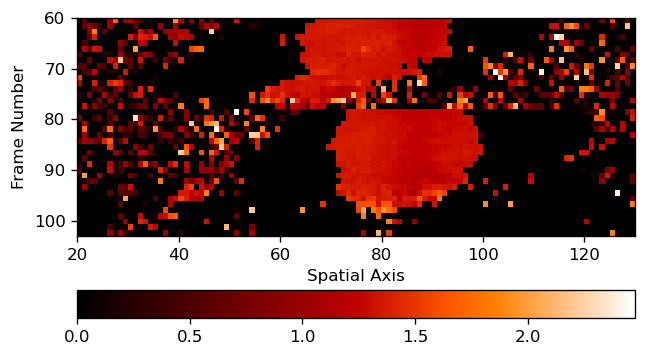

In [78]:
h3pa2 = np.vstack((h3p_a2_map))
h3pa2[h3pa2<0] = 0
h3pa2[h3pa2>2.5] = 0

plt.imshow(h3pa2, extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a2_map_554', bbox_inches='tight')

In [66]:
# create lmfit model with defined gaussian
h3p_model_2 = Model(gaussian_fit)

h3p_params_2 = h3p_model.make_params()
h3p_params_2.add('a0', value=0.1)
h3p_params_2.add('a1', value=853)
h3p_params_2.add('a2', value=1)
h3p_params_2.add('a3', value=0)
h3p_params_2.add('a4', value=0)
h3p_params_2.add('a5', value=0)

In [67]:
"""
repeat for h3p a0 at wavelength axis 874
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a0_map_2 = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a0_2 = np.zeros(upper_h3p-lower_h3p)
    #h3p_a0_error = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result_2 = h3p_model_2.fit(sky_subtract[j], h3p_params_2, x=pixel)
            h3p_a0_2[j] = h3p_fit_result_2.params['a0'].value
        except:
            pass
    h3p_a0_2[h3p_a0_2<0] = 0
    h3p_a0_2[h3p_a0_2>0.25] = 0
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a0_2)), h3p_a0_2)
    
    h3p_a0_map_2.append(h3p_a0_2)
    
print('Done')

Done


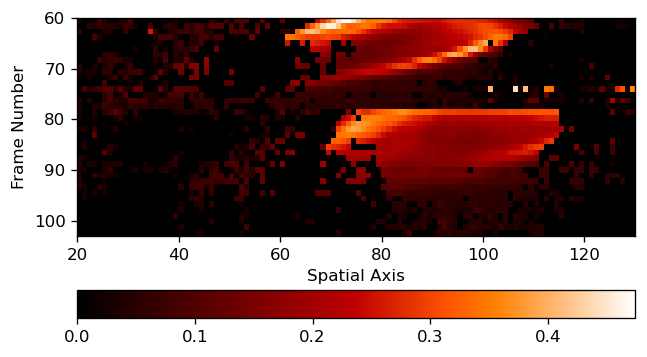

In [77]:
h3pa0_2 = np.vstack((h3p_a0_map_2))
h3pa0_2[h3pa0_2<0] = 0

plt.imshow(np.sqrt(h3pa0_2), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a0_map_874', bbox_inches='tight')

In [69]:
"""
repeat for h3p a1 at wavelength axis 874
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a1_map_2 = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a1_2 = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result_2 = h3p_model_2.fit(sky_subtract[j], h3p_params_2, x=pixel)
            h3p_a1_2[j] = h3p_fit_result_2.params['a1'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a1', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a1_2)), h3p_a1_2)
    
    h3p_a1_map_2.append(h3p_a1_2)
    
print('Done')

Done


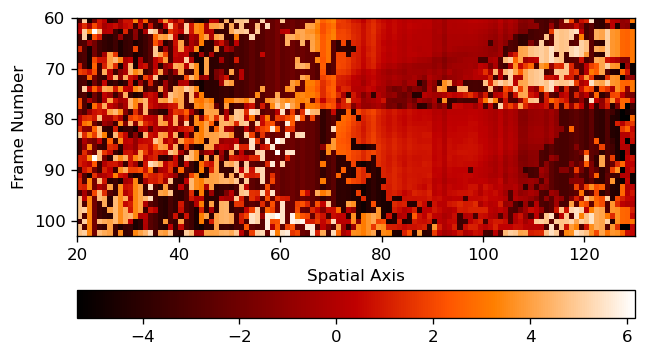

In [76]:
h3pa1_2 = np.vstack((h3p_a1_map_2))
h3pa1_2[h3pa1_2<849] = 849
h3pa1_2[h3pa1_2>857] = 857

plt.imshow(h3pa1_2-np.sum(h3pa1_2, axis=0)/len(h3pa1_2), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a1_map_874', bbox_inches='tight')

In [71]:
"""
repeat for h3p a2 at wavelength axis 874
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a2_map_2 = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a2_2 = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result_2 = h3p_model_2.fit(sky_subtract[j], h3p_params_2, x=pixel)
            h3p_a2_2[j] = h3p_fit_result_2.params['a2'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a2', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a2_2)), h3p_a2_2)
    
    h3p_a2_map_2.append(h3p_a2_2)
    
print('Done')

Done


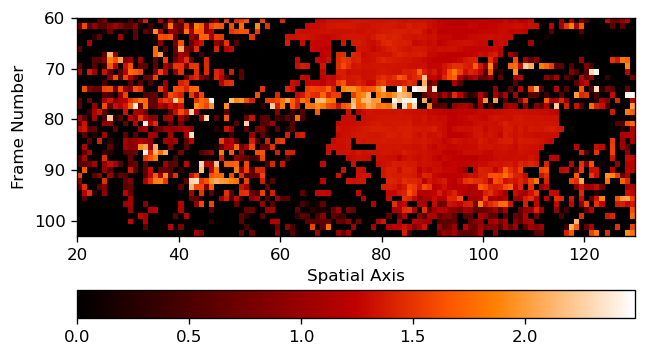

In [74]:
h3pa2_2 = np.vstack((h3p_a2_map_2))
h3pa2_2[h3pa2_2<0] = 0
h3pa2_2[h3pa2_2>2.5] = 0

plt.imshow(h3pa2_2, extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a2_map_874', bbox_inches='tight')

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(test, extent=[10, len(test[0]), end_kband_north, start_kband_north], cmap='gist_heat')
ax.set_xlabel('Spatial Axis')
ax.set_ylabel('Frame Number')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)

plt.colorbar(im, cax=cax)